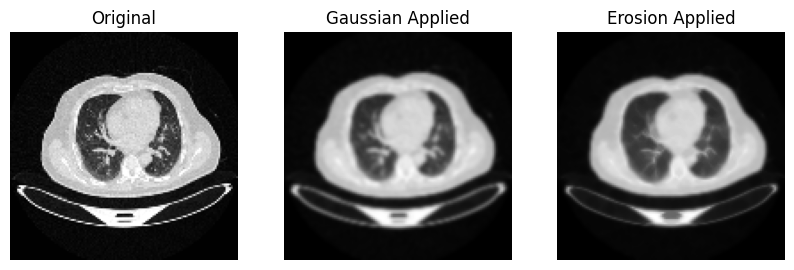

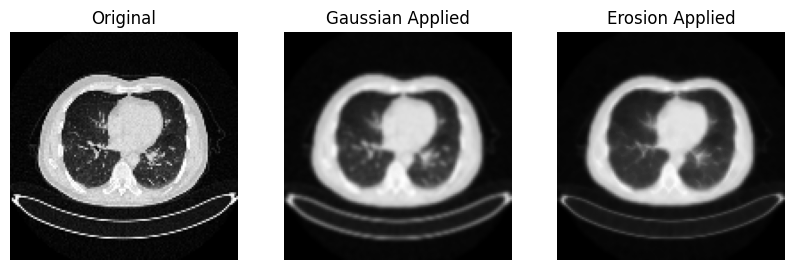

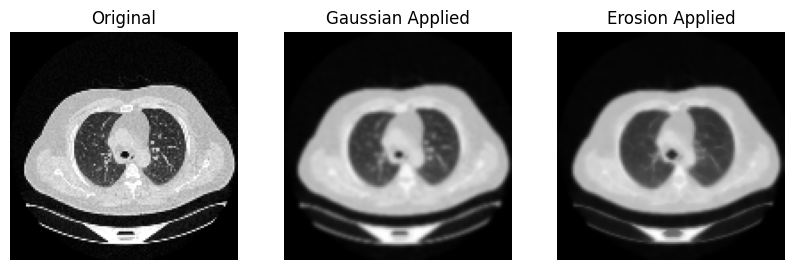

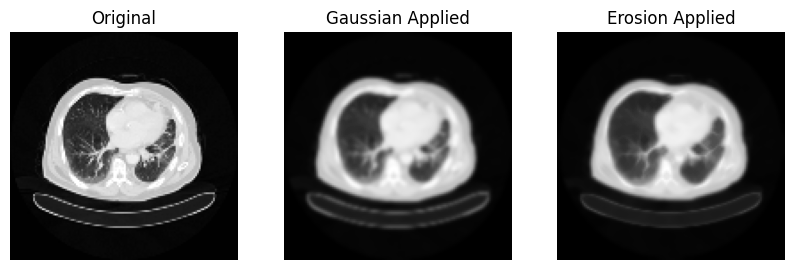

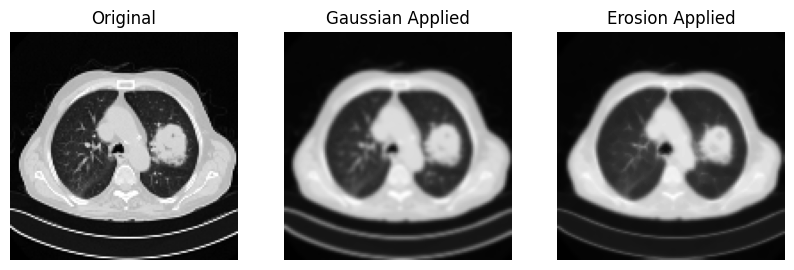

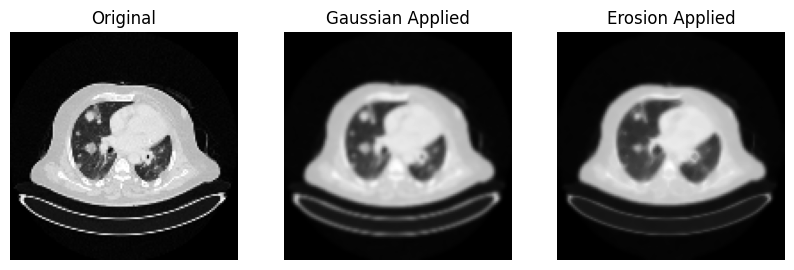

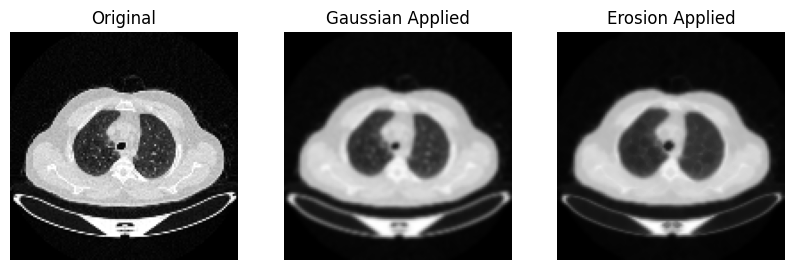

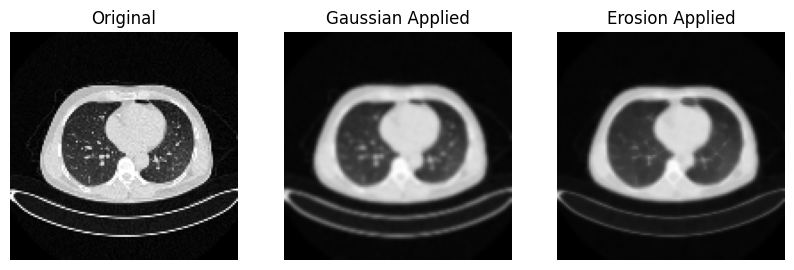

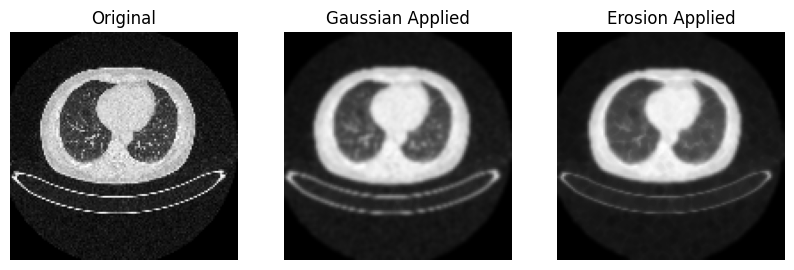

C:\Users\vishn\AppData\Local\Temp\ipykernel_4328\471389640.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette=["blue", "red", "green"])


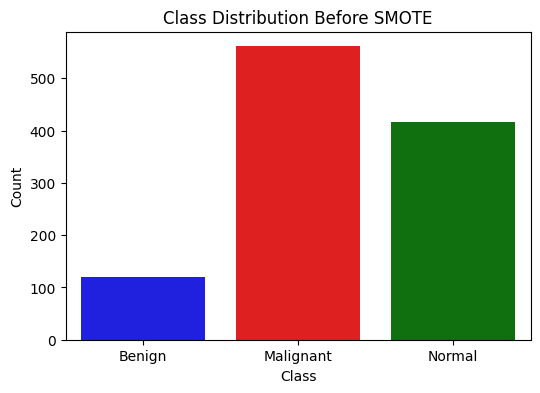

C:\Users\vishn\AppData\Local\Temp\ipykernel_4328\471389640.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette=["blue", "red", "green"])


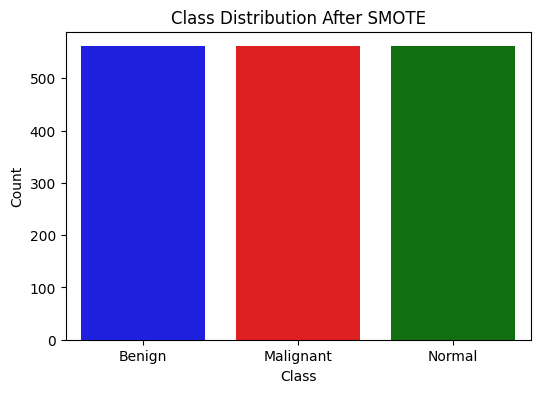

Accuracy: 93.18%
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       106
           1       0.98      0.98      0.98       125
           2       0.94      0.86      0.90       106

    accuracy                           0.93       337
   macro avg       0.93      0.93      0.93       337
weighted avg       0.93      0.93      0.93       337



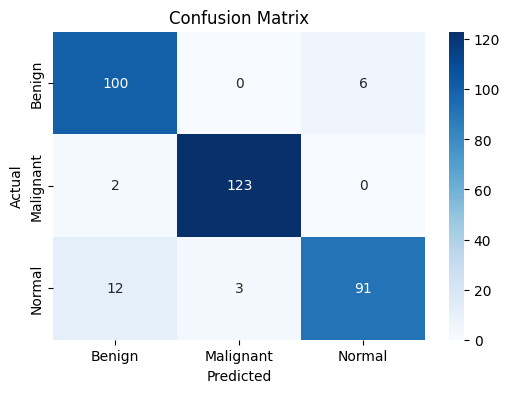

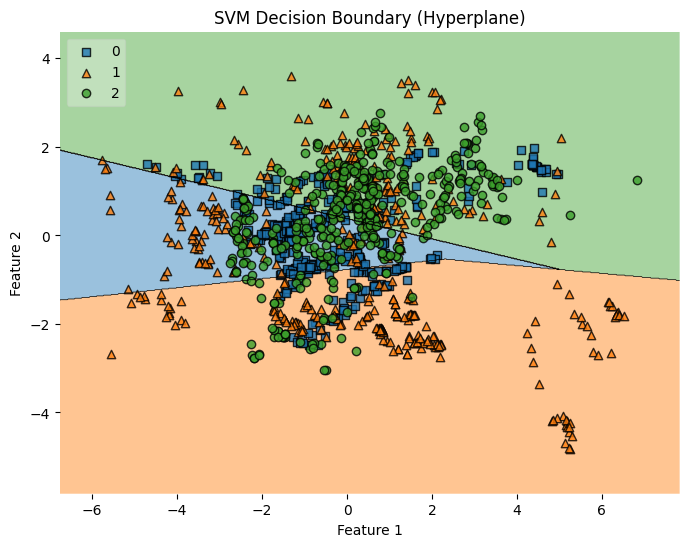

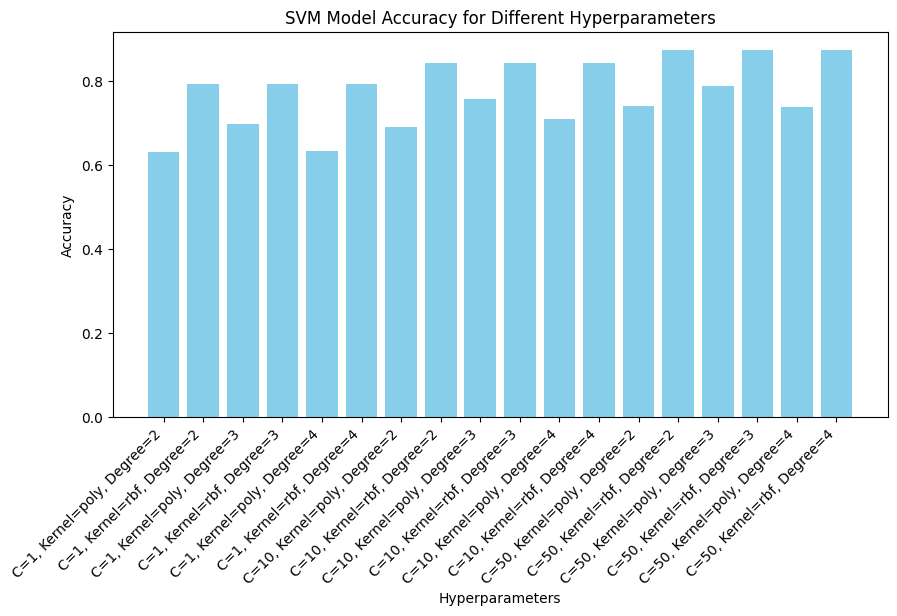

SVM Model Accuracy: 89.32%


In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import gaussian
from skimage.morphology import erosion, disk
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
import collections
from mlxtend.plotting import plot_decision_regions

# Define dataset paths
benign_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Benign cases"
malignant_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Malignant cases"
normal_path = "E:\\IQ-OTHNCCD _Lung _Cancer_Dataset\\Normal cases"

def preprocess_image(img, show_sample=False):
    img_resized = cv2.resize(img, (128, 128))
    img_gaussian = gaussian(img_resized, sigma=1)
    img_erosion = erosion(img_gaussian, disk(1))
    
    if show_sample:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_resized, cmap='gray')
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(img_gaussian, cmap='gray')
        plt.title("Gaussian Applied")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(img_erosion, cmap='gray')
        plt.title("Erosion Applied")
        plt.axis("off")
        
        plt.show()
    
    return img_erosion

def extract_features(img):
    gabor_responses = [gabor(img, frequency=0.6)[0], gabor(img, frequency=0.3)[0]]
    gabor_features = np.array([response.mean() for response in gabor_responses])
    
    glcm = graycomatrix((img * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + (glcm == 0)))
    energy = graycoprops(glcm, 'ASM')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    return np.hstack([gabor_features, contrast, homogeneity, entropy, energy, correlation])

def load_images_with_features(folder, label, show_samples=False):
    features, labels = [], []
    sample_count = 0
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            show_sample = sample_count < 3 if show_samples else False
            img = preprocess_image(img, show_sample=show_sample)
            features.append(extract_features(img))
            labels.append(label)
            sample_count += 1
    return features, labels

benign_features, benign_labels = load_images_with_features(benign_path, label=0, show_samples=True)
malignant_features, malignant_labels = load_images_with_features(malignant_path, label=1, show_samples=True)
normal_features, normal_labels = load_images_with_features(normal_path, label=2, show_samples=True)

X = np.array(benign_features + malignant_features + normal_features)
y = np.array(benign_labels + malignant_labels + normal_labels)

# Class Distribution Before SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y, palette=["blue", "red", "green"])
plt.xticks(ticks=[0, 1, 2], labels=["Benign", "Malignant", "Normal"])
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Class Distribution After SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_resampled, palette=["blue", "red", "green"])
plt.xticks(ticks=[0, 1, 2], labels=["Benign", "Malignant", "Normal"])
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca_components = min(X_train.shape[0], X_train.shape[1])
pca = PCA(n_components=pca_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

param_grid = {'C': [1, 10, 50], 'kernel': ['poly', 'rbf'], 'degree': [2, 3, 4]}
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
ensemble_model = VotingClassifier(estimators=[('svm', best_svm), ('rf', rf_model), ('gb', gb_model)], voting='soft')
ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant', 'Normal'], yticklabels=['Benign', 'Malignant', 'Normal'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Train a separate SVM model with only 2 PCA components for visualization
if X_train.shape[1] >= 2:
    X_train_2D = X_train[:, :2]
    svm_2D = SVC(kernel='linear')
    svm_2D.fit(X_train_2D, y_train)
    
    plt.figure(figsize=(8, 6))
    plot_decision_regions(X_train_2D, y_train, clf=svm_2D, legend=2)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("SVM Decision Boundary (Hyperplane)")
    plt.show()



#graph



import matplotlib.pyplot as plt

# Extract results from GridSearchCV
results = grid_search.cv_results_
c_values = results['param_C'].data
degrees = results['param_degree'].data
kernels = results['param_kernel'].data
mean_test_scores = results['mean_test_score']

# Convert to dictionary for easy plotting
acc_data = {}
for c, kernel, degree, score in zip(c_values, kernels, degrees, mean_test_scores):
    key = f"C={c}, Kernel={kernel}, Degree={degree}"
    acc_data[key] = score

# Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.bar(acc_data.keys(), acc_data.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Hyperparameters")
plt.ylabel("Accuracy")
plt.title("SVM Model Accuracy for Different Hyperparameters")
plt.show()


svm_model = SVC(C=10, kernel='rbf', probability=True)  
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Model Accuracy: {accuracy_svm * 100:.2f}%")